# Анализ данных и проверка гипотез сервиса GoFast

Мне были переданы данные некоторых пользователей сервиса GoFast. В данном проекте я анализирую эти данные и проверяю различные гипотезы, которые могут помочь сервису нарастить свою прибыль.

**Столбцы датасета users:**
- `user_id` — уникальный идентификатор пользователя
- `name` - имя пользователя
- `age` - возраст
- `city` - город
- `subscription_type` - тип подписки (free, ultra)

**Столбцы датасета rides:**
- `user_id` - уникальный идентификатор пользователя
- `distance` - расстояние, которое пользователь проехал в текущей сессии (в метрах)
- `duration` - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
- `date` - дата совершения поездки

**Столбцы датасета subscriptions:**
- `subscription_type` - тип подписки
- `minute_price` - стоимость одной минуты поездки по данной подписке
- `start_ride_price` - стоимость начала поездки
- `subscription_fee` - стоимость ежемесячного платежа

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import seaborn as sns

#### Шаг 1. Загрузка данных

In [32]:
users = pd.read_csv('/datasets/users_go.csv')
rides = pd.read_csv('/datasets/rides_go.csv')
subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')

#### Шаг 2. Предобработка данных

In [33]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [34]:
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')
rides['date']

0       2021-01-01
1       2021-01-18
2       2021-04-20
3       2021-08-11
4       2021-08-28
           ...    
18063   2021-11-04
18064   2021-11-16
18065   2021-11-18
18066   2021-11-27
18067   2021-12-29
Name: date, Length: 18068, dtype: datetime64[ns]

In [35]:
rides['month_number'] = rides['date'].dt.month
rides['month_number']

0         1
1         1
2         4
3         8
4         8
         ..
18063    11
18064    11
18065    11
18066    11
18067    12
Name: month_number, Length: 18068, dtype: int64

##### Обработка пропусков и дубликатов в таблице users

In [36]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [37]:
users.head(10)

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
5,6,Регина,25,Краснодар,ultra
6,7,Игорь,23,Омск,ultra
7,8,Юрий,23,Краснодар,ultra
8,9,Ян,21,Пятигорск,ultra
9,10,Валерий,18,Екатеринбург,ultra


**По данным видно, что значения могут повторяться, так как одного и того же человека могут звать Алексеем и он может жить в Москве, имея подписку ultra. Проверим нулевых значений судя по методу users.info() в таблице нет, однако на всякий случай проверю. Также, проверю дубликаты в столбце user_id, так как идентификационный номер должен быть уникальным.**

In [38]:
users.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [39]:
users.duplicated().sum()

31

**Видно, что явные дубликаты присутсвуют. Перед тем, как их удалять, замерим процент потерь данных, чтобы уложиться в 5%.**

In [40]:
records = users.shape[0]
users.drop_duplicates(inplace=True)
loss_percentage = '{:.1%}'.format((records - users.shape[0]) / records)
loss_percentage

'2.0%'

**Теряем 2% данных, дубликаты можно убрать без существенной потери.**

In [41]:
users.duplicated().sum()

0

##### Обработка пропусков и дубликатов в таблице rides

In [42]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   user_id       18068 non-null  int64         
 1   distance      18068 non-null  float64       
 2   duration      18068 non-null  float64       
 3   date          18068 non-null  datetime64[ns]
 4   month_number  18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 705.9 KB


In [43]:
rides.isna().sum()

user_id         0
distance        0
duration        0
date            0
month_number    0
dtype: int64

In [44]:
rides.duplicated().sum()

0

**Дубликатов и пропусков в таблице rides нет.**

##### Обработка дубликатов и пропусков в таблице subscriptions

In [45]:
subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


In [46]:
subscriptions.isna().sum()

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

In [47]:
subscriptions.duplicated().sum()

0

**Дубликатов и пропусков в таблице subscriptions нет**

#### Шаг 3. Исследовательский анализ данных

##### Частота встречаемости городов

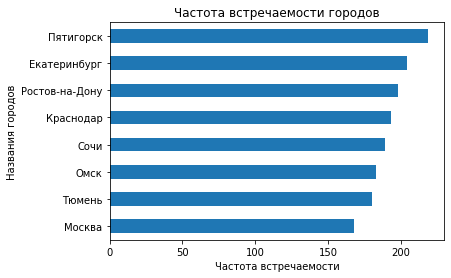

In [48]:
ax = users['city'].value_counts().sort_values(ascending=True) \
    .plot(kind='barh', y='city', title='Частота встречаемости городов');
ax.set_xlabel('Частота встречаемости')
ax.set_ylabel('Названия городов');

In [49]:
users['city'].describe()

count          1534
unique            8
top       Пятигорск
freq            219
Name: city, dtype: object

**В подписке чаще всего встречается Города Пятигорск и Екатеринбург. Возможно, это связано с тем, что Пятигорск по площади гораздо меньше Москвы и, соответственно, по меньшему городу на самокате перемещаться удобнее.**

##### Соотношение пользователей с подпиской и без подписки

Text(0.5, 1.0, 'Соотношение пользователей по подписке')

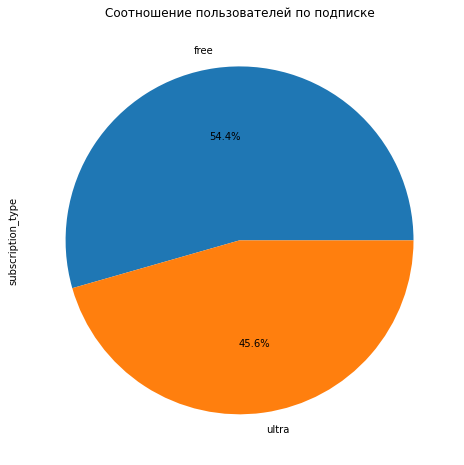

In [71]:
ax = users['subscription_type'].value_counts().plot(kind='pie', autopct='%.1f%%', figsize=(10, 8))
ax.set_title('Соотношение пользователей по подписке')

**Больше всего пользователей без подписки (54.4%). Возможно, это обусловлено тем, что пользователи не так часто пользуются сервисом и для них нет смысла покупать дополнительную подписку. Либо же, пользователи могут быть просто не осведомлены о наличии дополнительной подписки.**

##### Возраст пользователей

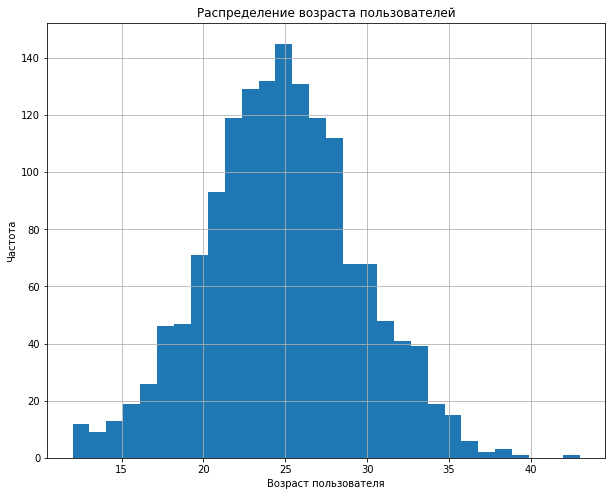

In [51]:
ax = users['age'].hist(figsize=(10, 8), bins=30)
ax.set_title('Распределение возраста пользователей')
ax.set_xlabel('Возраст пользователя')
ax.set_ylabel('Частота');

**Возраст пользователей в среднем распределился от 15 до 35 лет. Самый часто встречаемый возраст - 25 лет. Именно эта категория пользователей чаще всего пользуется сервисом.**

##### Расстояние, которое пользователь преодолел за одну поездку

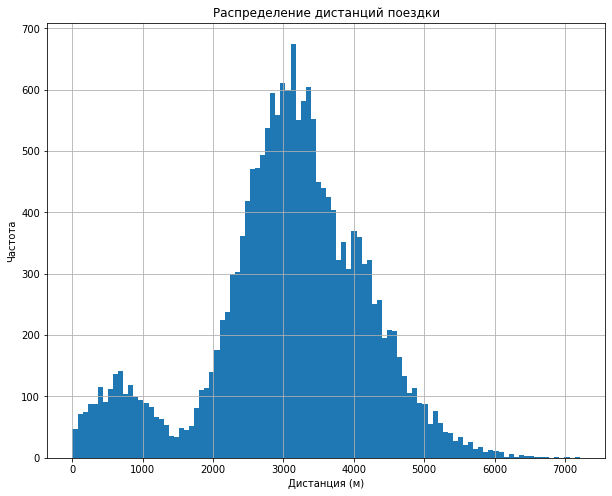

In [52]:
ax = rides['distance'].hist(bins=100, figsize=(10, 8))
ax.set_title('Распределение дистанций поездки')
ax.set_xlabel('Дистанция (м)')
ax.set_ylabel('Частота');

**В среднем, пользователи сервиса проезжают около 3-4км (3000-4000м) за сеанс.**

##### Продолжительность поездок

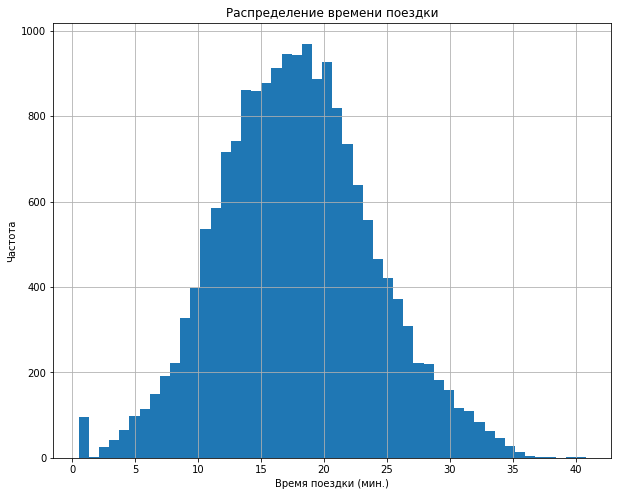

In [53]:
ax = rides['duration'].hist(bins=50, figsize=(10, 8))
ax.set_title('Распределение времени поездки')
ax.set_xlabel('Время поездки (мин.)')
ax.set_ylabel('Частота');

**В среднем одна поездка длится 15-25 минут.**

#### Шаг 4. Объединение данных

##### Объединение датафреймов

In [54]:
full_data = users.merge(rides, on='user_id')
full_data = full_data.merge(subscriptions, on='subscription_type')
full_data

,user_id,name,age,city,subscription_type,distance,duration,date,month_number,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11,8,50,0


In [55]:
# Отнимаем от суммы 2, так как две колонки объединяются и дублируют друг друга в итоговом подсчёте
all_columns_len = (users.shape[1] + rides.shape[1] + subscriptions.shape[1]) - 2
if all_columns_len == full_data.shape[1]:
    print('Все данные успешно объединены')
else:
    print('Не все данные успешно объединены')

Все данные успешно объединены


##### Обработка пользователей без подписки

In [56]:
data_without_subscription = full_data.query('subscription_type == "free"')

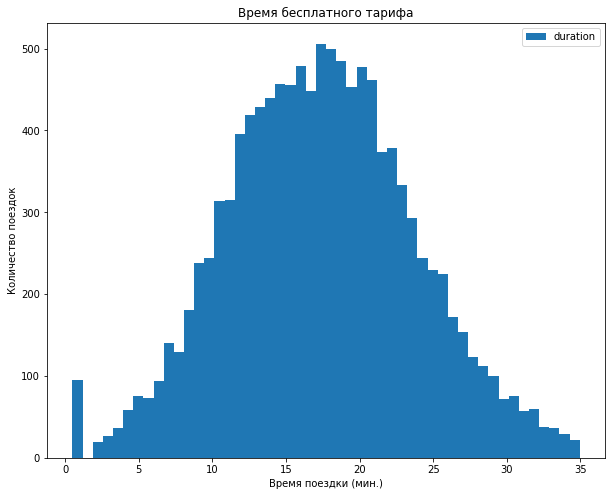

In [57]:
ax = data_without_subscription.plot(y='duration', 
                                    kind='hist', 
                                    bins=50, 
                                    figsize=(10, 8), 
                                    title='Время бесплатного тарифа')
ax.set_xlabel('Время поездки (мин.)')
ax.set_ylabel('Количество поездок')
plt.show()

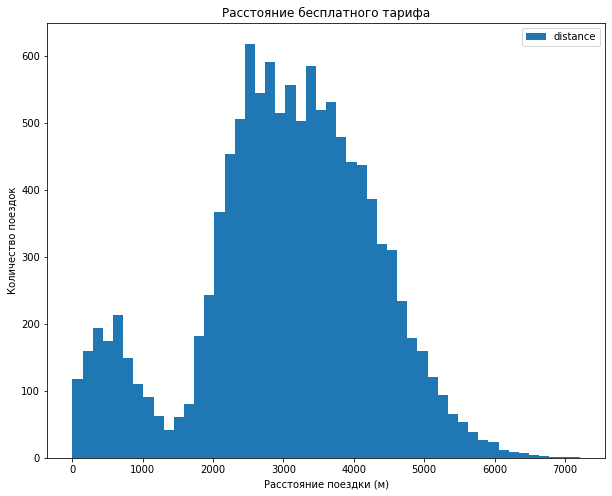

In [58]:
ax = data_without_subscription.plot(y='distance', 
                                    kind='hist', 
                                    bins=50, 
                                    figsize=(10, 8), 
                                    title='Расстояние бесплатного тарифа')
ax.set_xlabel('Расстояние поездки (м)')
ax.set_ylabel('Количество поездок')
plt.show()

**Для бесплатного тарифа характеры поездки от 10 до 25 минут, на расстояние от 2.5 до 4км.**

##### Обработка пользователей с подпиской

In [59]:
data_with_subscription = full_data.query('subscription_type == "ultra"')

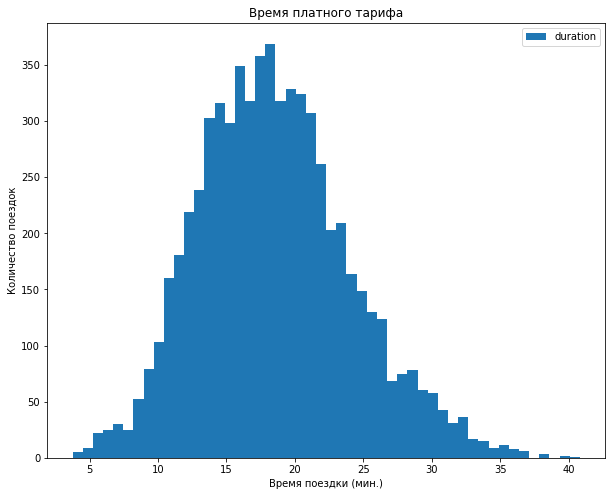

In [60]:
ax = data_with_subscription.plot(y='duration', 
                                 kind='hist', 
                                 bins=50, 
                                 figsize=(10, 8), 
                                 title='Время платного тарифа')
ax.set_xlabel('Время поездки (мин.)')
ax.set_ylabel('Количество поездок')
plt.show()

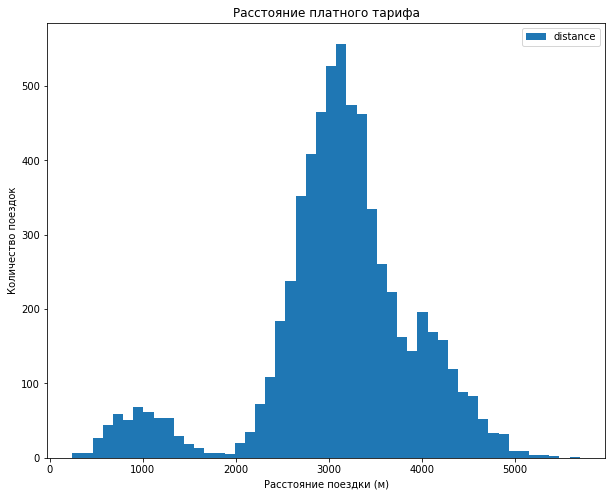

In [61]:
ax = data_with_subscription.plot(y='distance', 
                                 kind='hist', 
                                 bins=50, 
                                 figsize=(10, 8), 
                                 title='Расстояние платного тарифа')
ax.set_xlabel('Расстояние поездки (м)')
ax.set_ylabel('Количество поездок')
plt.show()

**Для пользователей с подпиской харакерты поездки от 10 до 20 минут, с расстоянием от 3 до 3.5км.**

**Общий вывод:**

Был создан новый датафрейм full_data, который содержит все данные из трех датафреймов
Создали отдельные два датафрейма data_without_subscription и data_with_subscription дляразделения пользователей по категориям без подписки/с подпиской

Выяснено, что пользователи без подписки в среднем тратят на дорогу от 10 до 25 минут и проезжают расстояние от 2.5 до 4 км.
Выяснено, что пользователи с подпиской в среднем тратят на дорогу от 10 до 20 минут и проезжают расстояние от 3 до 3.5 км.

#### Шаг 5. Подсчёт выручки

In [62]:
total_data = full_data.pivot_table(index=['month_number', 'user_id'],
                                  values=['distance', 'duration', 'name', 'subscription_type'],
                                  aggfunc={
                                      'distance': 'sum',
                                      'duration': 'sum',
                                      'name': 'count',
                                      'subscription_type': min
                                  })
total_data.head(20)

distance   duration  name subscription_type
month_number user_id                                                
1            1        7027.511294  41.416640     2             ultra
             3        3061.777147  12.654443     1             ultra
             5        3914.646990  12.395153     1             ultra
             7        6478.080979  27.653450     2             ultra
             12       3577.151148  32.462907     1             ultra
             13       6687.987446  41.848947     2             ultra
             14       7699.643820  33.700853     2             ultra
             15       4187.621459  38.125729     1             ultra
             20       3516.719208  28.231012     1             ultra
             22       3058.692225  12.328329     1             ultra
             25       3440.353053  16.321059     1             ultra
             26       6545.964099  26.263965     2             ultra
             30       7774.720501  24.472432     2             ultra
             32       3734.993902  24.674970     1             ultra
             35       9707.810053  56.087585     3             ultra
             42       4329.769187  22.983550     1             ultra
             43       6322.206034  46.786070     2             ultra
             44       2944.410629  18.484695     2             ultra
             45       3702.424319  26.405653     2             ultra
             46       3242.092435  19.707777     1             ultra

In [63]:
total_data['duration'] = np.ceil(total_data['duration'])

In [64]:
def get_revenue(row):
    if row['subscription_type'] == 'free':
        return 8 * row['duration'] + 50
    elif row['subscription_type'] == 'ultra':
        return 6 * row['duration'] + 199
    else:
        return 'ошибка'

In [65]:
total_data['revenue_per_month'] = total_data.apply(get_revenue, axis=1)

In [66]:
total_data['revenue_per_month'].head(20)

month_number  user_id
1             1          451.0
              3          277.0
              5          277.0
              7          367.0
              12         397.0
              13         451.0
              14         403.0
              15         433.0
              20         373.0
              22         277.0
              25         301.0
              26         361.0
              30         349.0
              32         349.0
              35         541.0
              42         337.0
              43         481.0
              44         313.0
              45         361.0
              46         319.0
Name: revenue_per_month, dtype: float64

**Общий вывод:**

Была создана сводная таблица total_data, в которой агрегированны данные о поездках на основе датафрейма full_data с объединёнными данными

Был проведен анализ данных пользователей, в результате которого было вычислено суммарное расстояние, количество поездок и общее время, проведенное каждым пользователем за каждый месяц. Кроме того, в таблицу был добавлен столбец, отражающий помесячную выручку, полученную от каждого пользователя.

#### Шаг 6. Проверка гипотез

##### Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверьте гипотезу. Используйте исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.

Проверим гипотезу **Пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки.**

H0: Время пользователей с подпиской **ultra** равно времени пользователей с подпиской **free**

H1: Время пользователей с подпиской **ultra** больше времени пользователей с подпиской **free**

In [67]:
with_subs_duration = data_with_subscription['duration']
without_subs_duration = data_without_subscription['duration']

results = st.ttest_ind(with_subs_duration, without_subs_duration, alternative='greater')
alpha = .05

print(results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

1.2804098316645618e-34
Отвергаем нулевую гипотезу


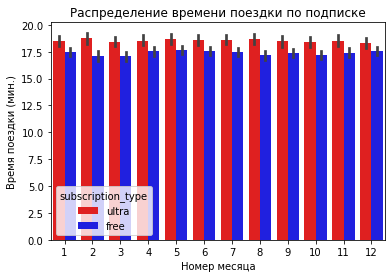

In [68]:
ax = sns.barplot(
    x='month_number',
    y='duration',
    hue='subscription_type',
    data=full_data,
    palette=['red', 'blue'],
)
ax.set_title('Распределение времени поездки по подписке')
ax.set_xlabel('Номер месяца')
ax.set_ylabel('Время поездки (мин.)');

**Я проверил и опроверг гипотезу о том, что время поездок равно для людей без подписки и с подпиской "ultra". Гипотезу H1, о том, что время поездки подписчиков "ultra" больше времени людей без подписки, опровергнуть не удалось.**

##### Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? Проверьте гипотезу и сделайте выводы.

Проверим гипотезу **Расстояние каждой поездки пользователей с подпиской не превышает 3130 метров**

H0: Расстояние пользователей с подпиской равно 3130 метрам

H1: Расстояние пользователей с подпиской меньше 3130 метров

In [69]:
with_subs_distance = data_with_subscription['distance']
interested_value = 3130
alpha = .05

results = st.ttest_1samp(
    with_subs_distance,
    interested_value,
    alternative='less'
)

print(results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

0.08046311521502146
Не удалось отвергнуть нулевую гипотезу


**Гипотеза была проверена, в итоге мы не можем сказать, что пользователи с подпиской проезжают не более 3130 метров.**

##### Проверьте гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Сделайте вывод.

Проверим гипотезу **Выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки**

H0: Выручка от пользователей с подпиской равна выручке от пользователей без подписки

H1: Выручка от пользователей с подпиской больше выручки от пользователей без подписки

In [70]:
with_subs_rev_per_month = total_data[total_data['subscription_type'] == 'ultra']['revenue_per_month']
without_subs_rev_per_month = total_data[total_data['subscription_type'] == 'free']['revenue_per_month']
alpha = .05

results = st.ttest_ind(
    with_subs_rev_per_month,
    without_subs_rev_per_month,
    alternative='greater'
)
print(results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

1.577594269237221e-195
Отвергаем нулевую гипотезу


**Нулевая гипотеза была опровергнута, так что мы можем сделать вывод, что выручка от пользователей с подпиской больше выручки, чем от пользователей без подписки.**

##### Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Я буду использовать гипотезу среднего для парных выборок.
Они будут сформулированы по типу:

H0: μ1=μ2

H1: μ1!=μ2

Где μ - это количество обращений в техподдержку.
Метод бы я использовал **scipy.stats.ttest_rel()**

#### Общий вывод

1. Первоначальная обработка данных
    * Тип столбца date был приведен к типу pandas.datetime.
    * Был добавлен столбец month_number, который содержит в себе номер месяца
    * В таблице users был устранен 31 пропуск, что составило 2% потери данных
2. Исследовательский анализ данных
    * В подписке чаще всего встречается Города Пятигорск и Екатеринбург. Возможно, это связано с тем, что Пятигорск по площади гораздо меньше Москвы и, соответственно, по меньшему городу на самокате перемещаться удобнее.
    * Больше всего пользователей без подписки (54.4%). Возможно, это обусловлено тем, что пользователи не так часто пользуются сервисом и для них нет смысла покупать дополнительную подписку. Либо же, пользователи могут быть просто не осведомлены о наличии дополнительной подписки.
    * Возраст пользователей в среднем распределился от 15 до 35 лет. Самый часто встречаемый возраст - 25 лет. Именно эта категория пользователей чаще всего пользуется сервисом.
    * В среднем, пользователи сервиса проезжают около 3-4км (3000-4000м) за сеанс.
    * В среднем одна поездка длится 15-25 минут.
3. Объединение данных
    * Был создан новый датафрейм full_data, который содержит все данные из трех датафреймов. Создали отдельные два датафрейма data_without_subscription и data_with_subscription дляразделения пользователей по категориям без подписки/с подпиской. Выяснено, что пользователи без подписки в среднем тратят на дорогу от 10 до 25 минут и проезжают расстояние от 2.5 до 4 км. Выяснено, что пользователи с подпиской в среднем тратят на дорогу от 10 до 20 минут и проезжают расстояние от 3 до 3.5 км.
4. Подсчет выручки
    * Была создана сводная таблица total_data, в которой агрегированны данные о поездках на основе датафрейма full_data с объединёнными данными. Был проведен анализ данных пользователей, в результате которого было вычислено суммарное расстояние, количество поездок и общее время, проведенное каждым пользователем за каждый месяц. Кроме того, в таблицу был добавлен столбец, отражающий помесячную выручку, полученную от каждого пользователя.
5. Проверка гипотез
    1. Я проверил и опроверг гипотезу о том, что время поездок равно для людей без подписки и с подпиской "ultra". Гипотезу H1, о том, что время поездки подписчиков "ultra" больше времени людей без подписки, опровергнуть не удалось.
    2. Гипотеза была проверена, в итоге мы не можем сказать, что пользователи с подпиской проезжают не более 3130 метров.
    3. Нулевая гипотеза была опровергнута, так что мы можем сделать вывод, что выручка от пользователей с подпиской больше выручки, чем от пользователей без подписки.